#LSTM Examples

##1: Install packages

In [2]:
!pip install yfinance tensorflow scikit-learn matplotlib


#2: Build and Train LSTM Models

In [3]:
# Imprort data
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Download Amazon and S&P 500 data
start_date = '2018-01-01'
end_date = '2024-09-15'

# Fetch data from Yahoo Finance
amzn_data = yf.download('AMZN', start=start_date, end=end_date)
sp500_data = yf.download('^GSPC', start=start_date, end=end_date)

# Keep only 'Adj Close' prices
amzn_data = amzn_data[['Adj Close']].rename(columns={'Adj Close': 'AMZN'})
sp500_data = sp500_data[['Adj Close']].rename(columns={'Adj Close': 'SP500'})

# Merge the two datasets on date
data = pd.concat([amzn_data, sp500_data], axis=1)

# Dropping missing values
data.dropna(inplace=True)

# Create lag features for S&P 500 (previous 10 days for richer context)
for i in range(1, 11):
    data[f'SP500_lag{i}'] = data['SP500'].shift(i)

# Remove rows with NaN values after creating lags
data.dropna(inplace=True)

# Define features (S&P 500 lags) and target (AMZN price)
X = data[[f'SP500_lag{i}' for i in range(1, 11)]]
y = data['AMZN']

# Scaling the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshaping for LSTM [samples, time steps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split (80% training, 20% testing)
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


##Building Model

In [4]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, 10)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30))

# Compile the model
#model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


##Evaluation

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 50)               │          12,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           1,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,792 (397.63 KB)

 Trainable params: 33,930 (132.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 67,862 (265.09 KB)

In [6]:
# prompt: evaluate the model with mae, mse, rmse, r squared
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
# y_pred contains the model's predictions on the test set
y_pred = model.predict(X_test)

# Take the first prediction from y_pred to match the shape of y_test
y_pred = y_pred[:, 0] # Select only the first prediction for each sample
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
# Calculate RMSE
rmse = np.sqrt(mse)
# Calculate R-squared
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Mean Absolute Error (MAE): 0.09968788343711851
Mean Squared Error (MSE): 0.013754183531460032
Root Mean Squared Error (RMSE): 0.11727823127699373
R-squared (R2): 0.5623481891989158


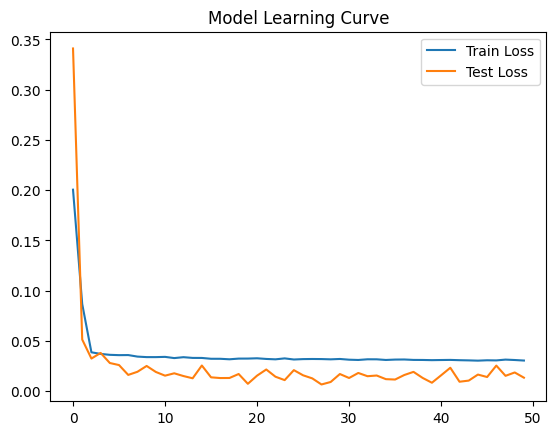

In [7]:
# Plot learning curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.title('Model Learning Curve')
plt.show()


##Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


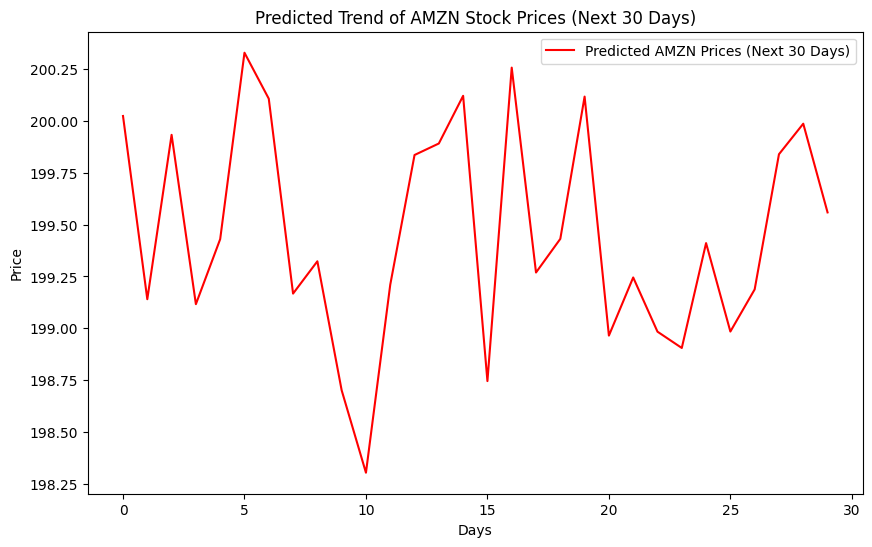

In [8]:
# Predicting the next 30 days based on S&P 500 index
def predict_next_30_days(model, last_10_days_sp500, scaler_y):
    # Reshape last 10 days of SP500 for prediction
    input_seq = last_10_days_sp500.reshape((1, 1, last_10_days_sp500.shape[0]))

    # Predict the next 30 days
    predicted_30_days = model.predict(input_seq)

    # Rescale the predicted prices back to the original scale
    predictions_rescaled = scaler_y.inverse_transform(predicted_30_days)
    return predictions_rescaled

# Get the last 10 days of the S&P 500 data from the test set
last_10_days_sp500_scaled = X_scaled[-1, 0, :]  # Last row of X_test, last 10 days

# Predict the next 30 days for Amazon using the last S&P 500 values
predicted_30_days = predict_next_30_days(model, last_10_days_sp500_scaled, scaler_y)

# Plot the predicted trend
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 30), predicted_30_days.flatten(), label='Predicted AMZN Prices (Next 30 Days)', color='red')
plt.title('Predicted Trend of AMZN Stock Prices (Next 30 Days)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

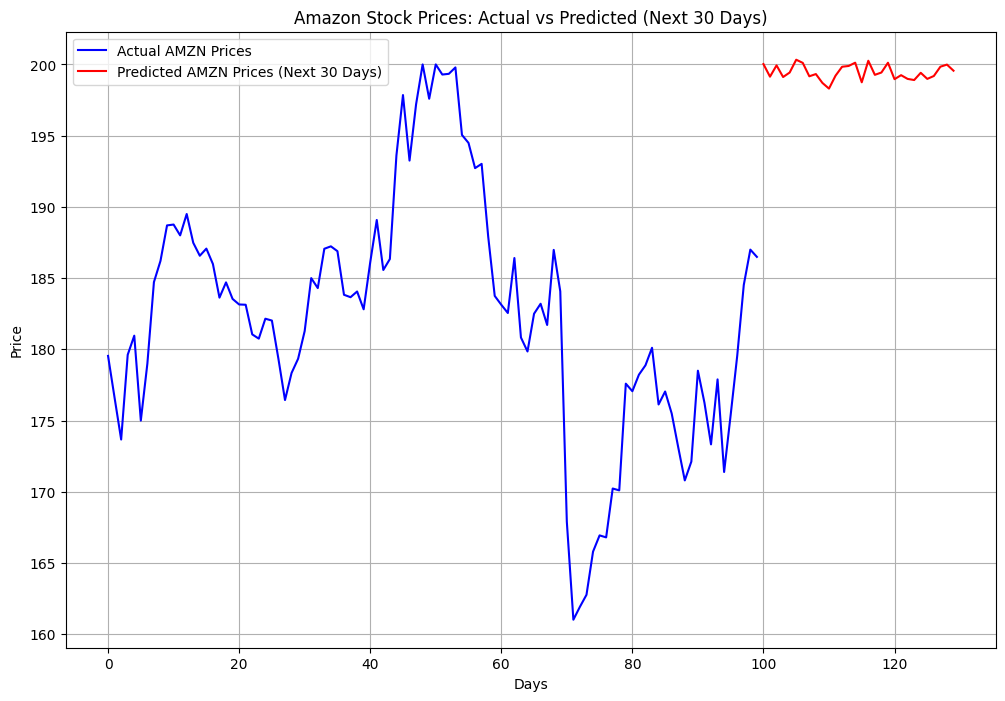

In [9]:
# Rescale y_test to original scale for comparison
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Prepare data for plotting
# Plot the actual prices (the last 100 days) and the predicted next 30 days
plt.figure(figsize=(12, 8))
plt.plot(np.arange(0, len(y_test_rescaled[-100:])), y_test_rescaled[-100:], label='Actual AMZN Prices', color='blue')
plt.plot(np.arange(len(y_test_rescaled[-100:]), len(y_test_rescaled[-100:]) + 30), predicted_30_days.flatten(), label='Predicted AMZN Prices (Next 30 Days)', color='red')
plt.title('Amazon Stock Prices: Actual vs Predicted (Next 30 Days)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#END

---
